In [1]:
import sys
import os
import pandas as pd


module_path = os.path.abspath(os.path.join('..', "openpolicedata"))
if module_path not in sys.path:
    sys.path.append(module_path)

import openpolicedata as opd
import numpy as np

pd.set_option('display.max_colwidth',100)

In [2]:
import requests
import json

def section_num_to_title(sect_num):
    # https://stackoverflow.com/questions/46604114/python-requests-ssl-error-certificate-verify-failed
    # https://stackoverflow.com/questions/28667684/python-requests-getting-sslerror
    # https://search.censys.io/hosts/198.246.135.19?resource=hosts&sort=RELEVANCE&per_page=25&virtual_hosts=EXCLUDE&q=law.lis.virginia.gov&at_time=2022-04-11T13%3A44%3A46.372Z
    path_to_cert = "C:\\Users\\matth\\repos\\CASH\\combo.pem"
    headers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36 Edg/100.0.1185.39"}
    d = requests.get(f"https://law.lis.virginia.gov/api/CoVSectionsGetSectionDetailsJson/{sect_num}/", verify=path_to_cert, headers=headers)

    d.text
    h = d.text
    h = json.loads(h)
    return h['ChapterList'][0]['SectionTitle']

def to_percent(x):
    return np.round(x/x.sum()*100,1)

In [3]:
src = opd.Source("Virginia")
data = src.load_from_url(year=2021, jurisdiction_filter="Herndon Police Department")
df = data.table

len(df)

6802

In [4]:
print(df["race"].value_counts())
print(df["ethnicity"].value_counts())

WHITE                        4948
BLACK OR AFRICAN AMERICAN    1150
ASIAN/PACIFIC ISLANDER        584
AMERICAN INDIAN               106
UNKNOWN                        14
Name: race, dtype: int64
NON-HISPANIC    4696
HISPANIC        1874
UNKNOWN          232
Name: ethnicity, dtype: int64


In [5]:
df["month"] = df["incident_date"].dt.to_period("M")
df["month"].unique()

df["race_eth"] = df["race"]
df.loc[df["ethnicity"] == "HISPANIC", "race_eth"] = "HISPANIC"
df.loc[df["ethnicity"] == "UNKNOWN", "race_eth"] = "UNKNOWN"

df["age_range"] = pd.cut(df["age"].astype(int),[-1,25,35,45,55,65, 200],labels=["16-25","26-35","36-45","46-55","56-65","65+"])

In [6]:
counts = df["residency"].value_counts()
perc = np.round(counts/counts.sum()*100,1)
sum_res = pd.DataFrame({'Count':counts,'Percent':perc})
sum_res

,Count,Percent
OTHER VIRGINIA JURISDICTION RESIDENT,1245,49.7
RESIDENT OF TOWN/CITY/COUNTY OF STOP,960,38.4
OUT OF STATE RESIDENT,229,9.1
UNKNOWN,69,2.8


In [7]:
pop = pd.Series([33.7, 36.9, 7.2, 18.5], index=["WHITE", "HISPANIC", "BLACK OR AFRICAN AMERICAN", "ASIAN/PACIFIC ISLANDER"],name="% Population")

stops_df = pd.DataFrame([pop])
index = [("",pop.name)]

actions = df["action_taken"].unique()

for i in range(len(actions)+1):
    if i == 0:
        tf = [True for x in range(len(df))]
        name = "Total"
    else:
        tf = df["action_taken"]==actions[i-1]
        name = actions[i-1]

    dfResCur = df[(df["residency"]=="RESIDENT OF TOWN/CITY/COUNTY OF STOP") & tf]
    dfNonRes = df[(df["residency"]!="RESIDENT OF TOWN/CITY/COUNTY OF STOP") & tf]
    stops = dfResCur["race_eth"].value_counts()
    total = stops.sum()
    stops_nonRes = dfNonRes["race_eth"].value_counts()
    total_nonRes = stops_nonRes.sum()
    stops = to_percent(stops)
    stops["Total"] = int(total)
    stops.name = "% Stops of Residents"
    stops_nonRes = to_percent(stops_nonRes)
    stops_nonRes["Total"] = int(total_nonRes)
    stops_nonRes.name = "% Stops of Non-Residents"

    index.append((name, stops.name))
    index.append((name, stops_nonRes.name))

    stops_df = pd.concat([stops_df,stops.to_frame().transpose(),stops_nonRes.to_frame().transpose()])

stops_df.index = pd.MultiIndex.from_tuples(index)

stops_df.fillna(0).convert_dtypes().drop(columns=["UNKNOWN","AMERICAN INDIAN"])


WHITE  HISPANIC  \
                      % Population               33.7      36.9   
Total                 % Stops of Residents       43.3      31.2   
                      % Stops of Non-Residents   43.4      26.9   
WARNING               % Stops of Residents       34.9      34.9   
                      % Stops of Non-Residents   38.1      28.5   
CITATION/SUMMONS      % Stops of Residents       49.3      27.7   
                      % Stops of Non-Residents   47.5      25.3   
ARREST                % Stops of Residents       33.3      66.7   
                      % Stops of Non-Residents   34.0      50.0   
NO ENFORCEMENT ACTION % Stops of Residents       43.8      37.5   
                      % Stops of Non-Residents   39.8      29.4   

                                                BLACK OR AFRICAN AMERICAN  \
                      % Population                                    7.2   
Total                 % Stops of Residents                           15.6   
                      % Stops of Non-Residents                       16.0   
WARNING               % Stops of Residents                           18.8   
                      % Stops of Non-Residents                       18.8   
CITATION/SUMMONS      % Stops of Residents                           13.8   
                      % Stops of Non-Residents                       14.1   
ARREST                % Stops of Residents                            0.0   
                      % Stops of Non-Residents                        8.0   
NO ENFORCEMENT ACTION % Stops of Residents                           18.8   
                      % Stops of Non-Residents                       15.9   

                                                ASIAN/PACIFIC ISLANDER  Total  
                      % Population                                18.5      0  
Total                 % Stops of Residents                         7.6    960  
                      % Stops of Non-Residents                     8.4   5842  
WARNING               % Stops of Residents                         8.0    373  
                      % Stops of Non-Residents                     9.3   2213  
CITATION/SUMMONS      % Stops of Residents                         7.7    556  
                      % Stops of Non-Residents                     8.2   3270  
ARREST                % Stops of Residents                         0.0     15  
                      % Stops of Non-Residents                     4.0     50  
NO ENFORCEMENT ACTION % Stops of Residents                         0.0     16  
                      % Stops of Non-Residents                     5.8    309

In [8]:
# Totals for reason for stop
df["reason_for_stop"].value_counts()

TRAFFIC VIOLATION      6265
EQUIPMENT VIOLATION     413
OTHER                    88
TERRY STOP               22
CALLS FOR SERVICE        14
Name: reason_for_stop, dtype: int64

month,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,Total
reason_for_stop,,,,,,,,,,,,,
CALLS FOR SERVICE,NaN,NaN,1.0,NaN,NaN,2.0,2.0,1.0,2.0,4.0,1.0,1.0,14.0
EQUIPMENT VIOLATION,75.0,58.0,52.0,28.0,19.0,16.0,20.0,25.0,22.0,22.0,39.0,37.0,413.0
OTHER,14.0,11.0,NaN,2.0,8.0,9.0,8.0,7.0,6.0,8.0,6.0,9.0,88.0
TERRY STOP,NaN,NaN,8.0,NaN,3.0,1.0,3.0,1.0,NaN,1.0,1.0,4.0,22.0
TRAFFIC VIOLATION,564.0,460.0,735.0,587.0,532.0,485.0,446.0,481.0,537.0,478.0,503.0,457.0,6265.0


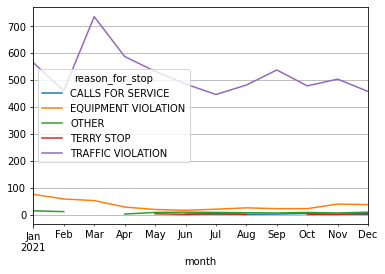

In [9]:
a = df#[df["reason_for_stop"] == "EQUIPMENT VIOLATION"]
a = a.groupby(["month","reason_for_stop"]).size().unstack("reason_for_stop")
a.plot.line(grid=True)
a=a.transpose()
a["Total"] = a.transpose().sum()
a

Text(0, 0.5, 'TRAFFIC VIOLATION')

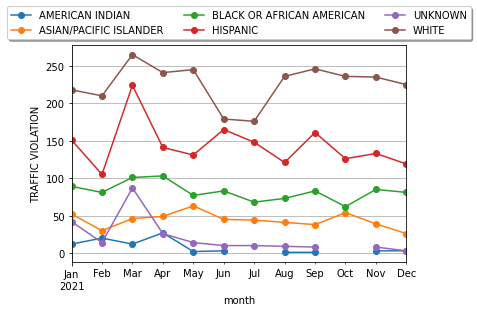

In [10]:
reason = "TRAFFIC VIOLATION"

a = df[df["reason_for_stop"] == reason]
a = a.groupby(["month","race_eth"]).size().unstack("race_eth")

# (a.loc["2021-03"] - a.mean())/a.mean()*100
ax = a.plot.line(grid=True, marker="o")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True)
ax.set_ylabel(reason)

In [11]:
reason = "TERRY STOP"  # CALLS FOR SERVICE 

a = df[df["reason_for_stop"] == reason]
b = a.groupby(["race_eth"]).size()
b

race_eth
BLACK OR AFRICAN AMERICAN     4
HISPANIC                     15
UNKNOWN                       1
WHITE                         2
dtype: int64

In [16]:
new_df = df[df["reason_for_stop"] == "TERRY STOP"]#"TRAFFIC VIOLATION"]
new_df = df.copy()
action_by_race = new_df.groupby(["action_taken","race_eth"]).size().unstack("race_eth")
action_by_race = action_by_race[["BLACK OR AFRICAN AMERICAN", "HISPANIC", "WHITE", "ASIAN/PACIFIC ISLANDER"]]
perc_by_race = np.round(action_by_race / action_by_race.sum() *100,1)
perc_by_race.columns = pd.MultiIndex.from_product([["Percent"], perc_by_race.columns], names=["Metric", "Race/Ethnicity"])
action_by_race.columns = pd.MultiIndex.from_product([["Count"], action_by_race.columns], names=["Metric", "Race/Ethnicity"])
A = pd.concat([action_by_race, perc_by_race], axis=1)
A = A.swaplevel(axis=1)
A.sort_index(axis=1, level=0, inplace=True)
A

# action_by_race.fillna(0).convert_dtypes()
# perc_by_race.transpose()


Race/Ethnicity        ASIAN/PACIFIC ISLANDER          \
Metric                                 Count Percent   
action_taken                                           
ARREST                                     2     0.4   
CITATION/SUMMONS                         311    54.9   
NO ENFORCEMENT ACTION                     18     3.2   
WARNING                                  235    41.5   

Race/Ethnicity        BLACK OR AFRICAN AMERICAN         HISPANIC          \
Metric                                    Count Percent    Count Percent   
action_taken                                                               
ARREST                                        4     0.4       35     1.9   
CITATION/SUMMONS                            539    49.8      982    52.4   
NO ENFORCEMENT ACTION                        52     4.8       97     5.2   
WARNING                                     487    45.0      760    40.6   

Race/Ethnicity        WHITE          
Metric                Count Percent  
action_taken                         
ARREST                   22     0.7  
CITATION/SUMMONS       1827    61.9  
NO ENFORCEMENT ACTION   130     4.4  
WARNING                 974    33.0

In [11]:
# Totals for people searched
df["person_searched"].value_counts()

NO     6744
YES      58
Name: person_searched, dtype: int64

In [31]:
new_df = df
# new_df = df[df["reason_for_stop"] == "TRAFFIC VIOLATION"]
action_by_race = new_df.groupby(["person_searched","race_eth"]).size().unstack("race_eth")
perc_by_race = np.round(action_by_race / action_by_race.sum() *100,1)

action_by_race
perc_by_race

race_eth,AMERICAN INDIAN,ASIAN/PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC,UNKNOWN,WHITE
person_searched,,,,,,
NO,86.0,562.0,1077.0,1847.0,240.0,2932.0
YES,NaN,4.0,5.0,27.0,1.0,21.0


(0.0, 8.0)

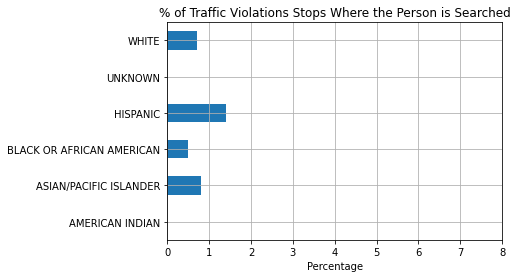

In [51]:
ax = perc_by_race.fillna(0).transpose().plot.barh(y="YES", grid=True, legend=False)
ax.set_ylabel("")
ax.set_xlabel("Percentage")
ax.set_title("Percentage of Stops Where the Person is Searched")
ax.set_xlim((0, 14.8))

In [88]:
actions = list(df["action_taken"].unique())

cols = []
searches_action = df[df["action_taken"] == a].groupby(["person_searched","race_eth"]).size().unstack("race_eth")

for a in actions:
    searches_action = df[df["action_taken"] == a].groupby(["person_searched","race_eth"]).size().unstack("race_eth")
    if "YES" in searches_action.index:
        cols.append(searches_action.loc["YES"])
    else:
        cols.append(pd.Series([0 for x in searches_action.columns], index=searches_action.columns))

total = df.groupby(["person_searched","race_eth"]).size().unstack("race_eth").loc["YES"]
actions.append("TOTAL")
cols.append(total)
actions.append("Search Rate")
cols.append(np.round(total / df["race_eth"].value_counts()*100,1))

last = pd.MultiIndex.from_tuples([(actions[-1], "")])
col_names = pd.MultiIndex.from_product([["# of Searches"], actions[:-1]]).append(last)
df_searches = pd.DataFrame(cols).transpose().fillna(0).convert_dtypes()
df_searches.columns = col_names
df_searches


# of Searches                          \
                                WARNING CITATION/SUMMONS ARREST   
AMERICAN INDIAN                       0                0      0   
ASIAN/PACIFIC ISLANDER                1                2      1   
BLACK OR AFRICAN AMERICAN             1                1      3   
HISPANIC                              1                0     26   
UNKNOWN                               0                0      1   
WHITE                                 1                2     18   

                                                      Search Rate  
                          NO ENFORCEMENT ACTION TOTAL              
AMERICAN INDIAN                               0     0         0.0  
ASIAN/PACIFIC ISLANDER                        0     4         0.7  
BLACK OR AFRICAN AMERICAN                     0     5         0.5  
HISPANIC                                      0    27         1.4  
UNKNOWN                                       0     1         0.4  
WHITE                                         0    21         0.7

In [14]:
new_df = df[df["action_taken"] != "ARREST"]
# new_df = df[df["reason_for_stop"] == "EQUIPMENT VIOLATION"]
action_by_race = new_df.groupby(["person_searched","race_eth"]).size().unstack("race_eth")
perc_by_race = np.round(action_by_race / action_by_race.sum() *100,1)

action_by_race
# perc_by_race

race_eth,AMERICAN INDIAN,ASIAN/PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC,UNKNOWN,WHITE
person_searched,,,,,,
NO,85.0,561.0,1076.0,1838.0,240.0,2928.0
YES,NaN,3.0,2.0,1.0,NaN,3.0


In [15]:
# Totals for vehicle search
df["vehicle_searched"].value_counts()

NO     6773
YES      29
Name: vehicle_searched, dtype: int64

In [16]:
new_df = df
# new_df = df[df["reason_for_stop"] == "EQUIPMENT VIOLATION"]
action_by_race = new_df.groupby(["vehicle_searched","race_eth"]).size().unstack("race_eth")
perc_by_race = np.round(action_by_race / action_by_race.sum() *100,1)

action_by_race
perc_by_race

race_eth,AMERICAN INDIAN,ASIAN/PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC,UNKNOWN,WHITE
vehicle_searched,,,,,,
NO,98.8,99.3,99.6,99.3,100.0,99.8
YES,1.2,0.7,0.4,0.7,NaN,0.2


In [17]:
new_df = df[df["action_taken"] != "ARREST"]
# new_df = df[df["reason_for_stop"] == "EQUIPMENT VIOLATION"]
action_by_race = new_df.groupby(["vehicle_searched","race_eth"]).size().unstack("race_eth")
perc_by_race = np.round(action_by_race / action_by_race.sum() *100,1)

action_by_race
# perc_by_race

race_eth,AMERICAN INDIAN,ASIAN/PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC,UNKNOWN,WHITE
vehicle_searched,,,,,,
NO,84.0,560.0,1074.0,1835.0,240.0,2928.0
YES,1.0,4.0,4.0,4.0,NaN,3.0


In [18]:
df.columns

Index(['incident_date', 'agency_name', 'jurisdiction', 'reason_for_stop',
       'race', 'ethnicity', 'age', 'gender', 'action_taken', 'violation_type',
       'specific_violation', 'person_searched', 'vehicle_searched',
       'additional_arrest', 'person_type', 'english_speaking',
       'physical_force_by_officer', 'physical_force_by_subject', 'residency',
       'month', 'race_eth'],
      dtype='object')

In [19]:
df["person_type"].value_counts()

DRIVER        3119
PEDESTRIAN      10
MISSING          3
Name: person_type, dtype: int64

In [20]:
df["english_speaking"].value_counts()

YES        2905
NO          224
MISSING       3
Name: english_speaking, dtype: int64

In [21]:
action_breakdown = df.groupby(["action_taken","english_speaking"]).size().unstack("english_speaking")
np.round(action_breakdown / action_breakdown.sum()*100,1)

english_speaking,MISSING,NO,YES
action_taken,,,
ARREST,NaN,2.7,0.8
CITATION/SUMMONS,100.0,58.0,58.9
NO ENFORCEMENT ACTION,NaN,4.0,1.4
WARNING,NaN,35.3,38.9


In [22]:
df.columns
df["physical_force_by_officer"].value_counts()

NO         3123
YES           6
MISSING       3
Name: physical_force_by_officer, dtype: int64

In [23]:
action_breakdown = df.groupby(["physical_force_by_officer","race_eth"]).size().unstack("race_eth")
np.round(action_breakdown / action_breakdown.sum()*100,1)
action_breakdown

race_eth,AMERICAN INDIAN,ASIAN/PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC,UNKNOWN,WHITE
physical_force_by_officer,,,,,,
MISSING,NaN,1.0,NaN,NaN,NaN,2.0
NO,9.0,262.0,491.0,868.0,41.0,1452.0
YES,NaN,NaN,NaN,2.0,NaN,4.0


In [24]:
df.groupby(["physical_force_by_officer","physical_force_by_subject"]).size().unstack("physical_force_by_subject")

physical_force_by_subject,MISSING,NO,YES
physical_force_by_officer,,,
MISSING,3.0,NaN,NaN
NO,NaN,3123.0,NaN
YES,NaN,NaN,6.0


In [25]:
df.groupby(["age","race_eth"]).size().unstack("race_eth")

race_eth,AMERICAN INDIAN,ASIAN/PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC,UNKNOWN,WHITE
age,,,,,,
0,NaN,NaN,NaN,NaN,1.0,NaN
16,NaN,1.0,2.0,12.0,3.0,7.0
17,NaN,2.0,6.0,24.0,7.0,30.0
18,NaN,6.0,4.0,41.0,4.0,48.0
19,1.0,6.0,8.0,56.0,7.0,47.0
...,...,...,...,...,...,...
82,NaN,NaN,1.0,NaN,NaN,2.0
83,NaN,NaN,NaN,1.0,NaN,NaN
84,NaN,NaN,NaN,1.0,NaN,NaN


In [26]:
stops_breakdown = df.groupby(["age_range","race_eth"]).size().unstack("race_eth")
np.round(stops_breakdown / stops_breakdown.sum()*100,1)
# stops_breakdown

race_eth,AMERICAN INDIAN,ASIAN/PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC,UNKNOWN,WHITE
age_range,,,,,,
16-25,8.1,12.9,20.3,24.1,26.6,19.0
26-35,29.1,31.4,31.3,28.7,28.2,28.5
36-45,25.6,24.0,22.4,23.8,19.5,20.0
46-55,18.6,17.5,15.0,14.5,14.1,16.2
56-65,14.0,11.1,7.7,6.9,8.7,10.2
65+,4.7,3.0,3.3,2.1,2.9,6.1


In [27]:
new_df = df[df["action_taken"]=="ARREST"]
action_breakdown = new_df.groupby(["age_range","race_eth"]).size().unstack("race_eth")
# np.round(action_breakdown / action_breakdown.sum()*100,1)
np.round(action_breakdown / stops_breakdown *100,1)

race_eth,AMERICAN INDIAN,ASIAN/PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC,UNKNOWN,WHITE
age_range,,,,,,
16-25,0.0,0.0,0.5,2.0,0.0,0.9
26-35,4.0,0.0,0.3,1.7,1.5,0.6
36-45,0.0,1.5,0.8,2.5,0.0,0.7
46-55,0.0,0.0,0.0,1.5,0.0,1.0
56-65,0.0,0.0,0.0,1.6,0.0,1.0
65+,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
a = df[df["reason_for_stop"] == "EQUIPMENT VIOLATION"]
len(a)

a = a[a["incident_date"] > "2021-04-30"]
# a = a[a["incident_date"] > "2021-10-31"]

a["specific_violation"].value_counts()
# a["incident_date"].min()

46.2-646     74
46.2-1030    52
46.2-1158    33
46.2-300      6
46.2-716      5
46.2-613      5
46.2-1003     3
46.2-715      3
46.2-1011     3
46.2-612      2
46.2-1034     1
46.2-600      1
46.2-722      1
46.2-818      1
46.2-1014     1
46.2-1013     1
46.2-712      1
Name: specific_violation, dtype: int64

In [29]:
a = df[df["reason_for_stop"] == "TERRY STOP"]

a.groupby(["action_taken","race_eth"]).size().unstack("race_eth").replace(np.nan,0).convert_dtypes(int)

,BLACK OR AFRICAN AMERICAN,HISPANIC,UNKNOWN,WHITE
action_taken,,,,
CITATION/SUMMONS,0,1,0,0
NO ENFORCEMENT ACTION,4,10,1,2
WARNING,0,4,0,0


In [30]:
a.groupby(["month","race_eth"]).size().unstack("race_eth").replace(np.nan,0).convert_dtypes(int)

,BLACK OR AFRICAN AMERICAN,HISPANIC,UNKNOWN,WHITE
month,,,,
2021-03,2,6,0,0
2021-05,1,1,1,0
2021-06,0,1,0,0
2021-07,0,3,0,0
2021-08,1,0,0,0
2021-10,0,1,0,0
2021-11,0,1,0,0
2021-12,0,2,0,2


In [31]:
b = a[a["month"]=="2021-03"]

b[["incident_date", "race","ethnicity","age","gender",'action_taken','specific_violation','person_searched','vehicle_searched',"person_type",'english_speaking','physical_force_by_officer','residency']]


,incident_date,race,ethnicity,age,gender,action_taken,specific_violation,person_searched,vehicle_searched,person_type,english_speaking,physical_force_by_officer,residency
281,2021-03-05,WHITE,HISPANIC,47,MALE,NO ENFORCEMENT ACTION,NaN,NO,NO,NaN,NaN,NaN,NaN
293,2021-03-06,WHITE,HISPANIC,31,MALE,NO ENFORCEMENT ACTION,NaN,NO,NO,NaN,NaN,NaN,NaN
294,2021-03-06,WHITE,HISPANIC,22,FEMALE,NO ENFORCEMENT ACTION,NaN,NO,NO,NaN,NaN,NaN,NaN
383,2021-03-11,WHITE,HISPANIC,23,MALE,WARNING,4.1-305,NO,NO,NaN,NaN,NaN,NaN
384,2021-03-11,WHITE,HISPANIC,30,MALE,WARNING,4.1-305,NO,NO,NaN,NaN,NaN,NaN
591,2021-03-16,BLACK OR AFRICAN AMERICAN,NON-HISPANIC,35,FEMALE,NO ENFORCEMENT ACTION,NaN,NO,NO,NaN,NaN,NaN,NaN
649,2021-03-20,BLACK OR AFRICAN AMERICAN,NON-HISPANIC,24,MALE,NO ENFORCEMENT ACTION,NaN,NO,NO,NaN,NaN,NaN,NaN
936,2021-03-29,WHITE,HISPANIC,42,MALE,NO ENFORCEMENT ACTION,NaN,NO,NO,NaN,NaN,NaN,NaN


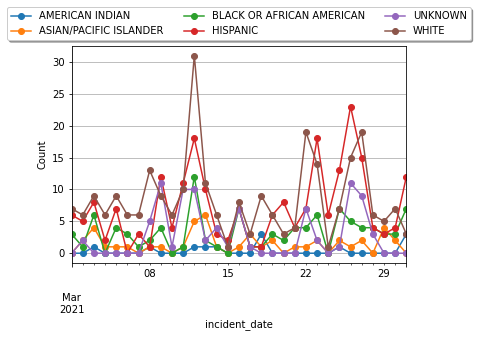

In [77]:
a = df[(df["reason_for_stop"] == "TRAFFIC VIOLATION") & (df["month"] == "2021-03")]

b = a.groupby(["incident_date","race_eth"]).size().unstack("race_eth").replace(np.nan,0).convert_dtypes(int)
ax = b.plot(grid=True,marker='o')
ax.set_ylabel('Count')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True)



In [87]:
a = df[(df["reason_for_stop"] == "TRAFFIC VIOLATION") & (df["month"] == "2021-03")] #  & ((df["ethnicity"]=="HISPANIC") | (df["ethnicity"]=="UNKNOWN"))

b = a.groupby(["age_range","race_eth"]).size().unstack("race_eth").replace(np.nan,0).convert_dtypes(int)
b


,AMERICAN INDIAN,ASIAN/PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC,UNKNOWN,WHITE
age_range,,,,,,
16-25,0,4,14,55,23,50
26-35,5,13,42,57,19,83
36-45,3,15,16,55,22,47
46-55,2,7,18,36,11,39
56-65,0,7,9,16,9,31
65+,2,0,2,5,3,15


In [89]:
b = a[a["race_eth"]=="WHITE"]["specific_violation"].value_counts(normalize=False)
c = a[a["race_eth"]=="HISPANIC"]["specific_violation"].value_counts(normalize=False)

df_viol = pd.DataFrame({"WHITE":b, "HISPANIC":c})
df_viol.sort_values("HISPANIC",ascending=False, inplace=True)

df_viol.fillna(0, inplace=True)
df_viol["WHITE"] = df_viol["WHITE"].astype(int)
df_viol["HISPANIC"] = df_viol["HISPANIC"].astype(int)

df_viol = df_viol[(df_viol["WHITE"]>=5) | (df_viol["HISPANIC"]>=5)]

titles = []
for num in df_viol.index:
    try:
        titles.append(section_num_to_title(num))
    except:
        titles.append("")

df_viol["Section Title"] = titles
df_viol_orig = df_viol.copy()

In [95]:
df_viol = df_viol_orig.copy()

tv = df[df["reason_for_stop"] == "TRAFFIC VIOLATION"]
violations_year_w = tv[tv["race_eth"]=="WHITE"]["specific_violation"].value_counts(normalize=False)
violations_year_h = tv[tv["race_eth"]=="HISPANIC"]["specific_violation"].value_counts(normalize=False)

perc_total_w = np.round(df_viol["WHITE"] / violations_year_w *100,1)
perc_total_w.dropna(inplace=True)
perc_total_h = np.round(df_viol["HISPANIC"] / violations_year_h *100,1)
perc_total_h.dropna(inplace=True)

df_viol["WHITE %"] = perc_total_w
df_viol["HISPANIC %"] = perc_total_h
df_viol.columns = pd.MultiIndex.from_tuples([("WHITE","# in March"),("HISPANIC","# in March"), ("","Section Title",),("WHITE","% for year"),("HISPANIC","% for year")])
df_viol = df_viol.reindex(columns=df_viol.columns[[0,3,1,4,2]])
df_viol

WHITE              HISPANIC             \
           # in March % for year # in March % for year   
46.2-830           63       11.8         64       20.0   
46.2-818.2         13       48.1         17       56.7   
46.2-300            7       13.2         17       11.5   
46.2-804           15       13.0         14       20.0   
46.2-835           16       17.8         12       20.0   
46.2-874           29       12.1         11       11.0   
42-8               14       11.6         11       14.7   
46.2-833.1          5       71.4         11       91.7   
46.2-833           19       15.4          8       12.3   
46.2-1158          16        5.4          8        8.8   
42-9                4        5.3          7       11.3   
46.2-646           16        7.0          5        8.9   
46.2-1030           6        9.8          5       10.0   
46.2-875           10        9.0          4        9.1   
46.2-821            9       15.5          2        5.3   

                                                               
                                                Section Title  
46.2-830    Uniform traffic control devices on highways; d...  
46.2-818.2  Use of handheld personal communications device...  
46.2-300        Driving without license prohibited; penalties  
46.2-804    Special regulations applicable on highways lan...  
46.2-835        Right turn on steady red light after stopping  
46.2-874    Maximum speed limit in business and residence ...  
42-8                                                           
46.2-833.1                 Evasion of traffic control devices  
46.2-833                              Traffic lights; penalty  
46.2-1158        Frequency of inspection; scope of inspection  
42-9                                                           
46.2-646               Expiration and renewal of registration  
46.2-1030   When lights to be lighted; number of lights to...  
46.2-875    Maximum speed limit on certain other highways ...  
46.2-821    Vehicles before entering certain highways shal...

In [90]:
b = a["specific_violation"].value_counts(normalize=False)

df_viol = pd.DataFrame({"TOTAL":b})
df_viol.sort_values("TOTAL",ascending=False, inplace=True)

df_viol.fillna(0, inplace=True)
df_viol["TOTAL"] = df_viol["TOTAL"].astype(int)

df_viol = df_viol[(df_viol["TOTAL"]>=5)]

titles = []
for num in df_viol.index:
    try:
        titles.append(section_num_to_title(num))
    except:
        titles.append("")

df_viol["Section Title"] = titles

tv = df[df["reason_for_stop"] == "TRAFFIC VIOLATION"]
violations_year = tv["specific_violation"].value_counts(normalize=False)

perc_total = np.round(df_viol["TOTAL"] / violations_year *100,1)
perc_total.dropna(inplace=True)

df_viol["TOTAL %"] = perc_total
df_viol.columns = pd.MultiIndex.from_tuples([("TOTAL","# in March"),("","Section Title",),("TOTAL","% for year")])
df_viol = df_viol.reindex(columns=df_viol.columns[[0,2,1]])
df_viol

TOTAL             \
            # in March % for year   
46.2-830           225       17.3   
46.2-874            53       11.2   
46.2-818.2          41       51.9   
42-8                40       13.3   
46.2-835            38       18.4   
46.2-833            38       13.1   
46.2-804            37       13.4   
46.2-1158           36        6.9   
46.2-646            33        8.1   
46.2-300            32       14.3   
46.2-875            23       10.0   
46.2-833.1          19       76.0   
46.2-1030           18       10.4   
42-9                15        7.4   
46.2-821            13        9.2   
46.2-845             6       18.8   
46.2-301             5        7.6   
46.2-1078.1          5       31.2   

                                                                                                                  
                                                                                                   Section Title  
46.2-830     Uniform traffic control devices on highways; drivers to obey traffic control devices; enforcemen...  
46.2-874                                                 Maximum speed limit in business and residence districts  
46.2-818.2        Use of handheld personal communications devices in certain motor vehicles; exceptions; penalty  
42-8                                                                                                              
46.2-835                                                           Right turn on steady red light after stopping  
46.2-833                                                                                 Traffic lights; penalty  
46.2-804                                   Special regulations applicable on highways laned for traffic; penalty  
46.2-1158                                                           Frequency of inspection; scope of inspection  
46.2-646                                                                  Expiration and renewal of registration  
46.2-300                                                           Driving without license prohibited; penalties  
46.2-875                                       Maximum speed limit on certain other highways in cities and towns  
46.2-833.1                                                                    Evasion of traffic control devices  
46.2-1030           When lights to be lighted; number of lights to be lighted at any time; use of warning lights  
42-9                                                                                                              
46.2-821                              Vehicles before entering certain highways shall stop or yield right-of-way  
46.2-845                                                                                   Limitation on U-turns  
46.2-301                               Driving while license, permit, or privilege to drive suspended or revoked  
46.2-1078.1                                                                                             Repealed

In [128]:
viol_counts = dfRes.groupby(["specific_violation","race_eth"]).size().unstack("race_eth").replace(np.nan,0).convert_dtypes(int)
total = viol_counts.sum(axis=1).astype(int)
viol_counts["TOTAL"] = total
# viol_counts.drop(columns="TOTAL").max(axis=1) == viol_counts["BLACK OR AFRICAN AMERICAN"]
viol_counts.drop(columns=["AMERICAN INDIAN", "ASIAN/PACIFIC ISLANDER","UNKNOWN"],inplace=True)

viol_counts = np.round(viol_counts.divide(total,axis=0)*100,1)
viol_counts["TOTAL"] = total
viol_counts.sort_values("TOTAL",ascending=False, inplace=True)
viol_counts

viol_counts = viol_counts[viol_counts["TOTAL"]>20]

titles = []
for num in viol_counts.index:
    try:
        titles.append(section_num_to_title(num))
    except:
        titles.append("")

viol_counts["Section Title"] = titles
viol_counts


,BLACK OR AFRICAN AMERICAN,HISPANIC,WHITE,TOTAL,Section Title
specific_violation,,,,,
46.2-830,15.0,23.0,46.0,100,Uniform traffic control devices on highways; d...
46.2-874,16.7,17.7,53.1,96,Maximum speed limit in business and residence ...
46.2-818,6.4,38.5,51.3,78,Stopping vehicle of another; blocking access t...
46.2-1030,22.0,37.3,23.7,59,When lights to be lighted; number of lights to...
46.2-804,19.6,26.8,42.9,56,Special regulations applicable on highways lan...
46.2-646,24.1,13.0,57.4,54,Expiration and renewal of registration
46.2-1158,16.0,22.0,60.0,50,Frequency of inspection; scope of inspection
46.2-833,22.2,22.2,44.4,45,Traffic lights; penalty
42-8,12.5,22.5,32.5,40,


In [152]:
df_warn_res = dfRes[dfRes["action_taken"]=="WARNING"]
df_warn = df[df["action_taken"]=="WARNING"]

print(len(dfRes) / len(df))
print(len(df_warn_res) / len(df_warn))

# df_warn = df_warn_res

df_warn = df_warn.groupby(["specific_violation","race_eth"]).size().unstack("race_eth").fillna(0).convert_dtypes(int)

total = df_warn.sum(axis=1).astype(int)
df_warn["TOTAL"] = total
# viol_counts.drop(columns="TOTAL").max(axis=1) == viol_counts["BLACK OR AFRICAN AMERICAN"]
df_warn.drop(columns=[ "AMERICAN INDIAN", "ASIAN/PACIFIC ISLANDER","UNKNOWN"],inplace=True)

df_warn = np.round(df_warn.divide(total,axis=0)*100,1)
df_warn["TOTAL"] = total
df_warn.sort_values("TOTAL",ascending=False, inplace=True)

df_warn.divide(df_warn["TOTAL"],axis=0)
df_warn["TOTAL"] = total
df_warn = df_warn[df_warn["TOTAL"] >10]

titles = []
for num in df_warn.index:
    try:
        titles.append(section_num_to_title(num))
    except:
        titles.append("")

df_warn["Section Title"] = titles

df_warn


0.14113496030579242
0.1442382057231245


,BLACK OR AFRICAN AMERICAN,HISPANIC,WHITE,TOTAL,Section Title
specific_violation,,,,,
46.2-830,17.7,23.8,42.2,593,Uniform traffic control devices on highways; drivers to obey traffic control devices; enforcemen...
46.2-804,21.4,27.7,42.3,220,Special regulations applicable on highways laned for traffic; penalty
46.2-1030,20.9,25.1,35.1,211,When lights to be lighted; number of lights to be lighted at any time; use of warning lights
46.2-874,16.5,31.7,41.5,164,Maximum speed limit in business and residence districts
46.2-646,22.3,21.7,43.9,157,Expiration and renewal of registration
46.2-833,19.8,26.7,36.6,131,Traffic lights; penalty
42-8,12.6,35.3,32.8,119,
42-9,7.6,39.0,23.7,118,
46.2-835,27.5,38.2,28.4,102,Right turn on steady red light after stopping


In [90]:
new_df = df[df["action_taken"] == "ARREST"]

viol_counts = new_df.groupby(["specific_violation","race_eth"]).size().unstack("race_eth").replace(np.nan,0).convert_dtypes(int)
total = viol_counts.sum(axis=1).astype(int)
viol_counts["TOTAL"] = total
# viol_counts.drop(columns="TOTAL").max(axis=1) == viol_counts["BLACK OR AFRICAN AMERICAN"]
viol_counts.drop(columns=["AMERICAN INDIAN", "ASIAN/PACIFIC ISLANDER","UNKNOWN"],inplace=True)

# viol_counts = np.round(viol_counts.divide(total,axis=0)*100,1)
viol_counts["TOTAL"] = total
viol_counts.sort_values("TOTAL",ascending=False, inplace=True)

titles = []
for num in viol_counts.index:
    try:
        titles.append(section_num_to_title(num))
    except:
        titles.append("")

viol_counts["Section Title"] = titles

t = viol_counts.sum()
t["Section Title"] = ""
t.name = "TOTAL"

viol_counts.append(t)

,BLACK OR AFRICAN AMERICAN,HISPANIC,WHITE,TOTAL,Section Title
specific_violation,,,,,
18.2-266,2,20,17,41,"Driving motor vehicle, engine, etc., while intoxicated, etc"
46.2-301,0,3,1,4,"Driving while license, permit, or privilege to drive suspended or revoked"
46.2-804,1,1,0,3,Special regulations applicable on highways laned for traffic; penalty
18.2-388,0,1,1,2,Intoxication in public; penalty; transportation of public inebriates to detoxification center
42-9,0,0,2,2,
46.2-300,0,2,0,2,Driving without license prohibited; penalties
46.2-921.1,0,1,1,2,Repealed
18.2-191,0,1,0,1,Definitions
19.2-128,0,1,0,1,Penalties for failure to appear
